In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from PIL import Image 
import sys
from IPython import display

import mxnet as mx

# Pre-process

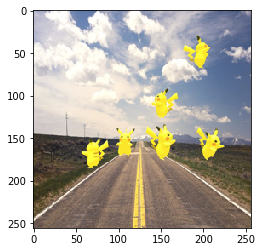

img (1, 3, 256, 256) type: <class 'numpy.ndarray'>
shape_dict {'data': (1, 3, 256, 256)}


In [2]:
def pre_process_data(path):
    img_= Image.open(path).resize((256, 256))
    plt.imshow(np.array(img_))
    plt.show()
    feature = np.array(img_).transpose((2, 0, 1))
    X = np.expand_dims(feature, axis=0)
    X = X.astype('float32')
    return X
    
pict = pre_process_data('pikachu.jpg')
print('img', pict.shape, 'type:', type(pict))
shape_dict = {'data': pict.shape}
print('shape_dict', shape_dict)

# Load the model from MXNet

In [3]:
# ssd_test-symbol.json
# ssd_test-0000.params
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='./mxnet_model/ssd_test_new', epoch=0)
print(sym)

<Symbol group [tinyssd5_concat0, tinyssd5_reshape0, tinyssd5_concat2]>


# Transform into TVM

In [4]:
import tvm
from tvm import relay
from tvm.contrib import graph_runtime

In [5]:
mod_, params_ = relay.frontend.from_mxnet(sym, shape_dict, arg_params=arg_params, aux_params=aux_params)
print(type(mod_))

<class 'tvm.ir.module.IRModule'>


In [6]:
target=tvm.target.create('llvm')
with tvm.transform.PassContext(opt_level=3):
    graph, lib, params = relay.build(mod_, target, params=params_)
    
ctx = tvm.cpu(0)
dtype = 'float32'
m = graph_runtime.create(graph, lib, ctx)

m.set_input('data', tvm.nd.array(pict))
m.set_input(**params)

m.run()

Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 3, 256, 256), 'float32'), ('TENSOR', (16, 3, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 16, 256, 256), 'float32'), ('TENSOR', (16, 16, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 16, 128, 128), 'float32'), ('TENSOR', (32, 16, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW', 'NCHW', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 32, 128, 128), 'float32'),

Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 16, 16, 16, 8), 'float32'), ('TENSOR', (16, 16, 3, 3, 8, 8), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 16, 8, 8, 8), 'float32'), ('TENSOR', (16, 16, 3, 3, 8, 8), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', (1, 8, 32, 32, 8), 'float32'), ('TENSOR', (1, 8, 3, 3, 8, 8), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'NCHW8c', 'NCHW8c', 'float32'). A fallback configuration is used, which may bring great performance regression.
Cannot find config for target=llvm -keys=cpu, workload=('conv2d_NCHWc.x86', ('TENSOR', 

# Display result

In [7]:
from mxnet import contrib, nd, image
from IPython import display

def predict(tvm_mod):
#     anchors, cls_preds, bbox_preds = tvm_output.get_output(0), tvm_output.get_output(1), tvm_output.get_output(2)
    anchors, cls_preds, bbox_preds = [nd.array(tvm_mod.get_output(i).asnumpy()) for i in range(3)]
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    print('Type anchors:{0} Shape: {1}\nType cls:{2} Shape: {3}\nType bbox:{4} Shape: {5}\nType cls_prob:{6} Shape: {7}'.format(type(anchors), anchors.shape, type(cls_preds), cls_preds.shape, type(bbox_preds), bbox_preds.shape, type(cls_probs), cls_probs.shape))
    
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors, nms_threshold=0.5)
    print(output[0])
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]


def display(img, output, thresh=0.5):
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.clf()
    plt.imshow(img)
    for row in output:
        cid = int(row[0])
        if cid < 0:
            continue
        score = row[1]
        if score < thresh:
            continue
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(row[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor='b', linewidth=3)
        plt.gca().add_patch(rect)
        text = 'pikachu'
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor='b', alpha=0.5),
                       fontsize=12, color='w')
#     plt.show()
    plt.savefig('output_pikachu.png')

In [8]:
out = predict(m)
print(type(out))
print(out)

Type anchors:<class 'mxnet.ndarray.ndarray.NDArray'> Shape: (1, 5444, 4)
Type cls:<class 'mxnet.ndarray.ndarray.NDArray'> Shape: (1, 5444, 2)
Type bbox:<class 'mxnet.ndarray.ndarray.NDArray'> Shape: (1, 21776)
Type cls_prob:<class 'mxnet.ndarray.ndarray.NDArray'> Shape: (1, 2, 5444)

[[ 0.          0.7410514   0.5107106   0.52425945  0.65384924  0.70115936]
 [ 0.          0.6953898   0.6955849   0.12191059  0.8254026   0.29198092]
 [-1.          0.67246056  0.5167549   0.5257029   0.6506756   0.693302  ]
 ...
 [-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.        ]]
<NDArray 5444x6 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[[0.         0.7410514  0.5107106  0.52425945 0.65384924 0.70115936]
 [0.         0.6953898  0.6955849  0.12191059 0.8254026  0.29198092]
 [0.         0.6493936  0.5458891  0.36101645 0.6672727

In [9]:
img_= Image.open('pikachu.jpg').resize((256, 256))
print(type(img_))

<class 'PIL.Image.Image'>


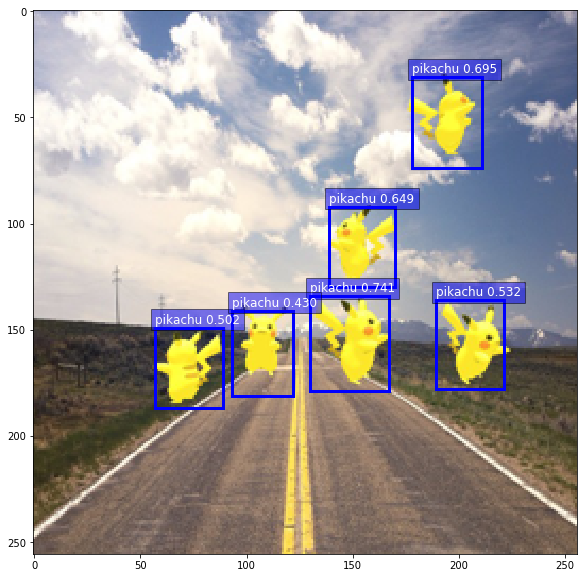

In [10]:
display(np.array(img_), out.asnumpy(), thresh=0.3)